# Data mining \& clustering

The goal if this practical is to adress the folowing problem:
<center style="color:red" >  Given XXX raw, unlabeled documents, ... How to exploit/understand/represent them?</center>

In the previous week, we have seen how to represent textual data with the Bag of Words (BoW) model:
$$X =
	\begin{matrix}
	 & \textbf{t}_j \\
	 & \downarrow \\
	\textbf{d}_i \rightarrow &
	\begin{pmatrix}
	x_{1,1} & \dots & x_{1,d} \\
	\vdots & \ddots & \vdots \\
	x_{N,1} & \dots & x_{N,d} \\
	\end{pmatrix}
	\end{matrix}
	$$

From this BoW representation, we want to answer the following questions:
1. Which clustering algorithm to choose?
    - K-means, LSA, pLSA, LDA
1. What results to expect?
    - Semantics, noise cleaning, etc...
1. Which qualitative and quantitative analyses to understand the groups?
[comment]: <> (%1. Comment boucler, itérer pour améliorer la qualité du processus?)


<span style="color:magenta" > In this practical, we use a **labeled dataset** in order to evaluate performances with quantitative and well-defined metrics. </span>


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import codecs
# import re
# import os.path
# import sklearn

## Data loading



In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

In [3]:
# conversion BoW + tf-idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)

# sparsity measure = 44 active words over 1000 per document (157 over 130000) !!
print(vectors.nnz / float(vectors.shape[0]))

(11314, 1000)
25.28902245006187


In [4]:
# retrieve words
print([(i,vectorizer.get_feature_names_out()[i]) \
       for i in np.random.randint(vectors.shape[1], size=10)])

[(np.int64(386), 'follow'), (np.int64(81), 'able'), (np.int64(672), 'period'), (np.int64(142), 'authority'), (np.int64(684), 'plan'), (np.int64(143), 'available'), (np.int64(438), 'happy'), (np.int64(648), 'opinion'), (np.int64(869), 'support'), (np.int64(6), '0d')]


In [5]:
# labels (only for evaluation)
Y = newsgroups_train.target
print(Y[:10])
print([newsgroups_train.target_names[y] for y in Y[:20]]) # vraie classe

[ 7  4  4  1 14 16 13  3  2  4]
['rec.autos', 'comp.sys.mac.hardware', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space', 'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'rec.motorcycles', 'talk.religion.misc', 'comp.sys.mac.hardware', 'sci.space', 'misc.forsale', 'alt.atheism', 'comp.graphics', 'rec.autos', 'sci.electronics', 'comp.windows.x']


# 0) Word clouds
### Drawing word clouds from the raw corpus or words' frequencies :  [make word clouds !](https://github.com/amueller/word_cloud)

### Installation
If you are using pip:

`pip install wordcloud`

### If you are using conda, you can install from the conda-forge channel:

`conda install -c conda-forge wordcloud`

### Let's look at the most frequent words in this dataset

In [6]:
data = np.array(newsgroups_train.data)
corpus = "".join(data)
words = corpus.split() # optional args to choose the splitting chars
print("Nb mots=",len(words))
# Lets find the most frequence words Your code here

Nb mots= 2098842


### Plot the N frequent words and verify that its follows a Zipf law

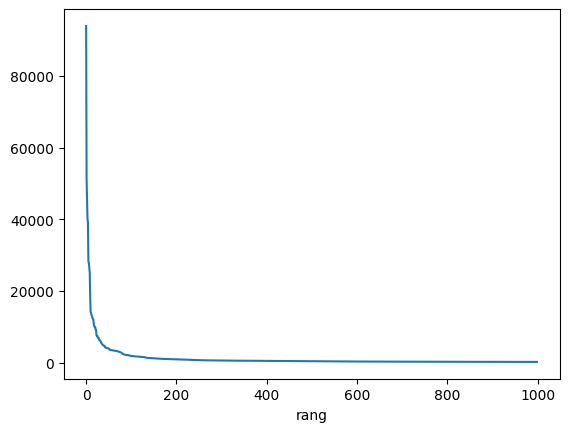

In [7]:
from collections import Counter

wc = Counter()
for text in words:
    # text = preprocess(text)
    wc.update(text.split(" "))

common_word = wc.most_common(1000)
freq = [f for w,f in common_word]

plt.figure()
plt.plot(freq[:1000])
plt.xlabel('rang')
# plt.ylabel('frequence')
plt.show()

### Experiment word clouds

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

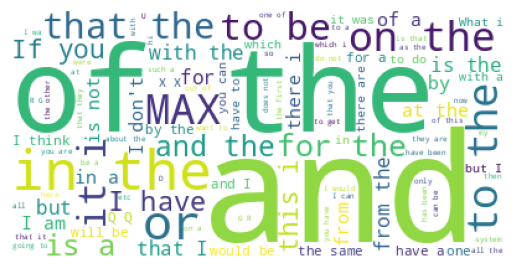

In [8]:
from wordcloud import STOPWORDS, WordCloud # Note: this is the default option for stopwords
STOPWORDS.add('AX')
wordcloud = WordCloud(background_color='white', stopwords = ['AX'], max_words=100).generate(corpus)

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

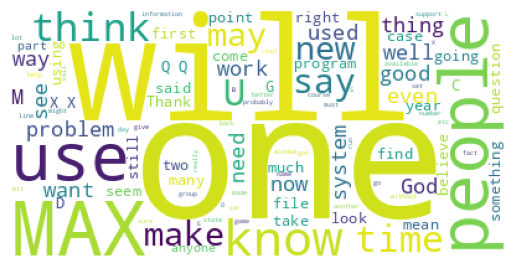

In [9]:
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=100).generate(corpus)

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

### Use word clouds with generate\_from\_frequencies.
N.B.: retrieve the most words frequencies using a CountVectorizer

In [10]:
Cvectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
X = Cvectorizer.fit_transform(words)

In [11]:
# w = Cvectorizer.get_feature_names_out()

### Drawing word clouds from classes


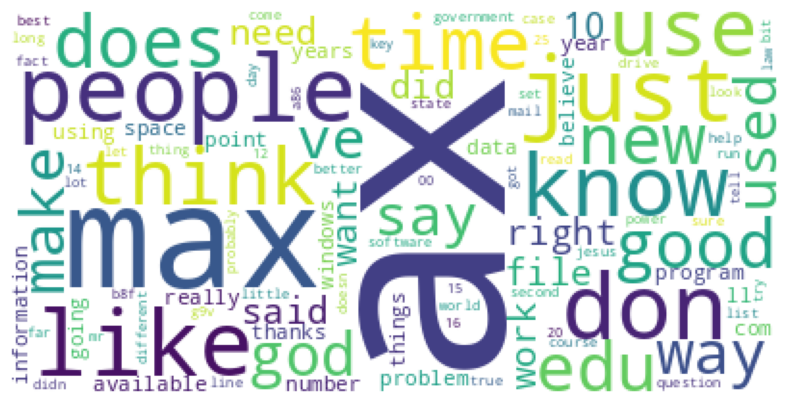

In [12]:
X = Cvectorizer.fit_transform(newsgroups_train.data)

word_freq = np.asarray(X.sum(axis=0)).flatten()
words = Cvectorizer.get_feature_names_out()

freq_dict = dict(zip(words, word_freq))

wordcloud = WordCloud(background_color="white", stopwords=STOPWORDS, max_words=100).generate_from_frequencies(freq_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# 1) Clustering algorithm: K-Means

**Let's start by the most famous and simple unsupervised algorithm: $k$-means!**
Look at [sklear documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
and apply it to your BoW matrix.


In [13]:
from sklearn.cluster import KMeans
# your code here
kmeans = KMeans(n_clusters=20, random_state=0, max_iter=10).fit(vectors)
# Getting clusters:
center = kmeans.cluster_centers_
feature_names = vectorizer.get_feature_names_out()
for i in range(20):
    indice_max = np.argmax(center[i])
    max_word = feature_names[indice_max]
    print(f"Cluster {i}: {max_word}")



# wordcloud = WordCloud(background_color="white", stopwords=STOPWORDS, max_words=100).generate(vectors)

# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

Cluster 0: 00
Cluster 1: people
Cluster 2: information
Cluster 3: file
Cluster 4: think
Cluster 5: sale
Cluster 6: don
Cluster 7: key
Cluster 8: thanks
Cluster 9: game
Cluster 10: did
Cluster 11: windows
Cluster 12: software
Cluster 13: edu
Cluster 14: space
Cluster 15: ve
Cluster 16: drive
Cluster 17: com
Cluster 18: card
Cluster 19: god


### Clustering Analysis:
1. **Qualtitative:**
    - Look at the most important words for each cluster
    - Perform cluster assignement to each document, and compute word cloud on the document (raw text or frequencies)
2. **Quantitative:**
    - Compute cluster "purity": $p_j= |y^*_j|$, where $y^*_j$ is the most frequent (GT) label in cluster $C_j$ $\Rightarrow$ $p = \frac{1}{N}\sum\limits_j  p_j$
    - Compute [Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html) and [Adjusted Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score)

# 2) Latent Semantic Analysis (LSA <=> SVD)


**Remember the LSA factorziation**:
$$
\begin{matrix}
 & X  &\!\!\!\!\!=\!\!\!\!\!& U  & \Sigma & V^T \\
  & \textbf{t}_j   &  & \hat{ \textbf{d}_i} & &  \\
 & \downarrow  &  &\downarrow  & & \\
\textbf{d}_i \rightarrow
&
\begin{pmatrix}
x_{1,1} & \dots & x_{1,d} \\
\\
\vdots & \ddots & \vdots \\
\\
x_{N,1} & \dots & x_{N,d} \\
\end{pmatrix}
&
\!\!\!\!\!=\!\!\!\!\!
%&
%(\hat{ \textbf{t}_j}) \rightarrow
&
\begin{pmatrix}
\begin{pmatrix} &  \textbf{u}_1 &  \end{pmatrix} \\
\vdots \\
\begin{pmatrix}  & \textbf{u}_k &  \end{pmatrix}
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix}
\sigma_1 & \dots & 0 \\
\vdots & \ddots & \vdots \\
0 & \dots & \sigma_k \\
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix}
\begin{pmatrix} \, \\ \, \\ \textbf{v}_1 \\ \, \\ \,\end{pmatrix}
\dots
\begin{pmatrix} \, \\ \, \\ \textbf{v}_k \\ \, \\ \, \end{pmatrix}
\end{pmatrix}
\end{matrix}
$$

- Look at [SVD doc in skelarn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)
- Do the same qualitative/quantitative evaluation than with K-Means
- You can also use LSA as a pre-processing step for K-Means, *i.e.* running K-Means on $\boldsymbol{U}$ matrix above
    - N.B. : try without/with $\ell_2$ normalization of $\boldsymbol{U}$'s rows before running  K-Means
    - You can also benefit from LSA pre-processing for using [t-SNE visualization](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (see code below)


In [14]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
tsne = TSNE(n_components=2, init='pca',max_iter=1000, verbose=1)

svd = TruncatedSVD(n_components=100, random_state=0)

U = svd.fit_transform(vectors)

tsne_mat = tsne.fit_transform(U)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11314 samples in 0.001s...
[t-SNE] Computed neighbors for 11314 samples in 0.428s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11314
[t-SNE] Computed conditional probabilities for sample 2000 / 11314
[t-SNE] Computed conditional probabilities for sample 3000 / 11314
[t-SNE] Computed conditional probabilities for sample 4000 / 11314
[t-SNE] Computed conditional probabilities for sample 5000 / 11314
[t-SNE] Computed conditional probabilities for sample 6000 / 11314
[t-SNE] Computed conditional probabilities for sample 7000 / 11314
[t-SNE] Computed conditional probabilities for sample 8000 / 11314
[t-SNE] Computed conditional probabilities for sample 9000 / 11314
[t-SNE] Computed conditional probabilities for sample 10000 / 11314
[t-SNE] Computed conditional probabilities for sample 11000 / 11314
[t-SNE] Computed conditional probabilities for sample 11314 / 11314
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence

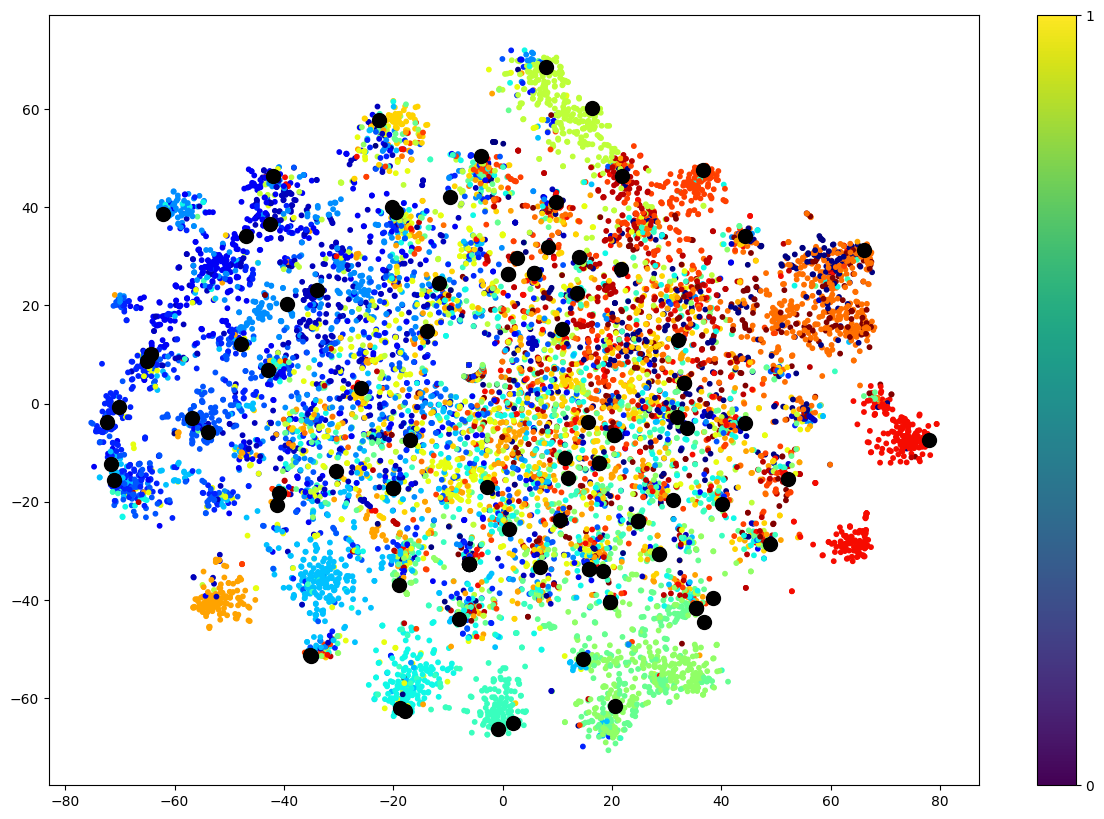

In [15]:
NN2cluster = np.argmax(np.abs(U), axis=0)

cmap = plt.colormaps.get_cmap("jet")

plt.figure(figsize=(15, 10))
plt.scatter(tsne_mat[:, 0], tsne_mat[:, 1], c=Y, cmap=cmap, s=10)
plt.scatter(tsne_mat[NN2cluster[:], 0], tsne_mat[NN2cluster[:], 1], c="black", s=100)
plt.colorbar(ticks=range(20))

# 3) Latent Dirichlet Allocation (LDA)

Perform the same experiments with LDA:
- LDA
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html


**Start with a CountVectorizer**

In [16]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer

# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r"\w+")

# Vectorize document using TF-IDF
vectorizer = CountVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 1),
    tokenizer=tokenizer.tokenize,
    token_pattern=None,
    max_df=0.95,
    min_df=2,
    max_features=1000,
)

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)
print(vectors.nnz / float(vectors.shape[0]))

(11314, 1000)
27.50114901891462


## LDA-viz

In [17]:
## pip install install pyldavis
from __future__ import print_function
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.lda_model

lda = LatentDirichletAllocation(n_components=20, random_state=0)
lda.fit(vectors)

pyLDAvis.enable_notebook()
pyLDAvis.lda_model.prepare(lda, vectors, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.294663 -0.175038       1        1  13.256653
5      0.217550  0.003684       2        1  12.613791
11    -0.350883 -0.102201       3        1   7.107022
3      0.129539 -0.089813       4        1   6.944048
14     0.226067  0.016862       5        1   6.285795
17     0.187561  0.033074       6        1   5.895809
10     0.163853  0.077750       7        1   5.331568
6      0.147452 -0.127773       8        1   5.071644
1      0.127258 -0.033229       9        1   4.569422
0     -0.311820  0.217251      10        1   4.340825
2      0.156668  0.082717      11        1   4.196352
15    -0.293879  0.195360      12        1   3.930386
13     0.154514  0.159658      13        1   3.923096
4     -0.323770 -0.117012      14        1   3.405768
8      0.099004  0.064277      15        1   3.077377
9      0.155411 -0.086637      16        1   2.651189
18    -0.027300 -0.191339      17        1   2.468048
7      0.116799  0.006294      18        1   2.260548
19     0.067418 -0.006229      19        1   1.739784
16    -0.346777  0.072344      20        1   0.930874, topic_info=    Term          Freq         Total Category  logprob  loglift
153   ax  62525.000000  62525.000000  Default  30.0000  30.0000
990    x   7686.000000   7686.000000  Default  29.0000  29.0000
9      1  11481.000000  11481.000000  Default  28.0000  28.0000
0      0   8634.000000   8634.000000  Default  27.0000  27.0000
28     2   8526.000000   8526.000000  Default  26.0000  26.0000
..   ...           ...           ...      ...      ...      ...
166  bhj     15.428002    460.835004  Topic20  -6.0595   1.2799
9      1     90.353243  11481.071500  Topic20  -4.2920  -0.1679
567    m     81.996609   9907.844344  Topic20  -4.3890  -0.1176
28     2     66.319767   8526.144168  Topic20  -4.6012  -0.1796
154    b     36.759774   2544.270835  Topic20  -5.1913   0.4396

[907 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.008339    0
0         3  0.152764    0
0         8  0.001042    0
0        10  0.597620    0
0        12  0.130990    0
...     ...       ...  ...
999       1  0.071797    z
999       3  0.378266    z
999       4  0.100515    z
999      13  0.001231    z
999      14  0.448011    z

[5092 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 6, 12, 4, 15, 18, 11, 7, 2, 1, 3, 16, 14, 5, 9, 10, 19, 8, 20, 17])

# Performances evaluation

**Compare the different approaches with two quantitative metrics.**

In [27]:
from sklearn.metrics import f1_score, adjusted_rand_score

n_clusters = 20

def evaluate_clustering(y_true, y_pred):
    return {
        "F1 (macro)": f1_score(y_true, y_pred, average="macro"),
        "ARI": adjusted_rand_score(y_true, y_pred)
    }




tfidf = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
X_tfidf = tfidf.fit_transform(newsgroups_train.data)

kmeans_tfidf = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
labels_tfidf = kmeans_tfidf.fit_predict(X_tfidf)

results_tfidf = evaluate_clustering(Y, labels_tfidf)



bow = CountVectorizer(stop_words="english", max_df=0.95, min_df=5)
X_bow = bow.fit_transform(newsgroups_train.data)

lda = LatentDirichletAllocation(n_components=n_clusters, random_state=0)
X_lda = lda.fit_transform(X_bow)

kmeans_lda = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_lda = kmeans_lda.fit_predict(X_lda)

results_lda = evaluate_clustering(Y, labels_lda)


In [ ]:
print(results_tfidf)
print(results_lda)

{'F1 (macro)': 0.07876258719204025, 'ARI': 0.06257401947269185}
{'F1 (macro)': 0.03619635409252209, 'ARI': 0.18805763599044334}


On a de meilleur resultat avec la tf-idf combiner au K-means